In [ ]:
!pip install rake-nltk
!pip install -U sentence-transformers

In [ ]:
from collections import Counter
import os
import math
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from rake_nltk import Rake,Metric
from sentence_transformers import SentenceTransformer, util


In [3]:
from collections import Counter

def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    ret = ""
    for i in range(0, len(data)):
    	if data[i] in symbols:
    		ret+=' '
    	else:
    		ret += data[i] 
    return ret

def getQueries(filename):
	file = open(filename, 'r')
	queries = []
	while(True):
		str = file.readline()
		if(str == ""):
			break
		prev = 'A'
		curr = 'A'
		i = 0
		while(True):
			prev = curr
			curr = str[i]
			if(prev == '|' and curr == '|'):
				break
			i+=1
		#pre-processing
		text = remove_punctuation(str[i+1:])
		queries.append(text)
	file.close()
	return queries

rake code

In [4]:
from codecs import getwriter
from sys import is_finalizing
from bs4 import BeautifulSoup
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import re

In [5]:
def extract_key(text, w, r):
	r.extract_keywords_from_text(text) 
	a = r.get_ranked_phrases()
	t = ""
	cut = min(w, len(a))
	count = 0
	for phrase in a:
		if count >= cut:
			break
		t = t + ' ' + phrase
		count += 1
	return t

In [ ]:
queryList = getQueries('./drive/MyDrive/AILA_2019_dataset/Query_doc.txt')
totalQueries = len(queryList)
r = Rake()
for i in range(0, totalQueries):
  queryList[i] = extract_key(queryList[i], 200, r)


print("step 1 complete")
print(queryList)
print(len(queryList))
print(type(queryList))


In [7]:
#reading relevant and non-relevant documents of the queries
file = open('./drive/MyDrive/AILA_2019_dataset/relevance_judgments_priorcases.txt', 'r')
queryRel = []
queryNonRel = []
for i in range(0, totalQueries):
	queryRel.append([])
	queryNonRel.append([])

#filling queryRel and queryNonRel
while(True):
	str1 = file.readline()
	if(str1 == ''):
		break
	str1 = str1.split()
	if(int(str1[3]) == 0):
		queryNonRel[int(str1[0][6:])-1].append(str1[2])
	else:
		queryRel[int(str1[0][6:])-1].append(str1[2])
file.close()
print("step 2 complete")


step 2 complete


In [25]:
#reading relevant and non-relevant documents of the queries
file = open('./drive/MyDrive/AILA_2019_dataset/relevance_judgments_statutes.txt', 'r')
queryRelS = []
queryNonRelS = []
for i in range(0, totalQueries):
	queryRelS.append([])
	queryNonRelS.append([])

#filling queryRel and queryNonRel
while(True):
	str1 = file.readline()
	if(str1 == ''):
		break
	str1 = str1.split()
	if(int(str1[3]) == 0):
		queryNonRelS[int(str1[0][6:])-1].append(str1[2])
	else:
		queryRelS[int(str1[0][6:])-1].append(str1[2])
file.close()
print("step 3 complete")


step 3 complete


In [8]:
caseDocs = os.listdir("./drive/MyDrive/AILA_2019_dataset/Object_casedocs")
statutesDocs = os.listdir("./drive/MyDrive/AILA_2019_dataset/Object_statutes")

In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [10]:
def readDoc(filename):
  file = open(filename, 'r')
  str = file.read()
  str.replace('\n', ' ')
  str = remove_punctuation(str)
  file.close()
  return str

In [11]:
def getRank(a, doc):
  for i in range(0, len(a)):
    if(a[i][0] == doc):
      return i+1
  return -1

In [12]:
caseData = []
for i in range(0, len(caseDocs)):
  doc = caseDocs[i]
  caseData.append(readDoc("./drive/MyDrive/AILA_2019_dataset/Object_casedocs/"+doc))
  caseData[i] = extract_key(caseData[i], 200, r)

In [13]:
statuteData = []
for i in range(0, len(statutesDocs)):
  doc = statutesDocs[i]
  statuteData.append(readDoc("./drive/MyDrive/AILA_2019_dataset/Object_statutes/"+doc))
  statuteData[i] = extract_key(statuteData[i], 200, r)


In [14]:
embedded_queries = model.encode(queryList)
embedded_cases = model.encode(caseData)
embedded_statutes = model.encode(statuteData)

In [15]:
similarityCaseDocs = np.zeros(shape=(50, len(caseDocs)))
for i in range(0, len(queryList)):
  for j in range(0, len(caseDocs)):
    similarity = np.array(util.pytorch_cos_sim(embedded_queries[i], embedded_cases[j]))
    similarityCaseDocs[i][j] = similarity[0][0]

In [17]:
similarityStatuteDocs = np.zeros(shape=(50, len(statutesDocs)))
for i in range(0, len(queryList)):
  for j in range(0, len(statutesDocs)):
    similarity = np.array(util.pytorch_cos_sim(embedded_queries[i], embedded_statutes[j]))
    similarityStatuteDocs[i][j] = similarity[0][0]

In [63]:
graphRanksCase = []
graphRanksStatutes = []
for i in range(0, 10):
  graphRanksCase.append(0)
for i in range(0, 20):
  graphRanksStatutes.append(0)

In [ ]:
print("For prior cases")
for i in range(0, len(queryList)):
  a = []
  for j in range(0, len(caseDocs)):
    a.append((caseDocs[j], similarityCaseDocs[i][j]))
  a.sort(key=lambda i:i[1],reverse=True)
  print("FOR query : "+str(i+1))
  print("Top five retrieved documents: ")
  for j in range(0, 5):
    print(a[j][0]+" "+str(a[j][1]))
  print("Ranks of given relevant documents: ")
  for j in range(0, len(queryRel[i])):
    rank = getRank(a, queryRel[i][j]+".txt")
    if(rank < 1000 and rank >= 0):
      graphRanksCase[rank//100]+=1
    print(queryRel[i][j]+" "+str(rank))
  print("\n")
print("-------------------------------------------")

In [ ]:
print("For statutes")
for i in range(0, len(queryList)):
  a = []
  for j in range(0, len(statutesDocs)):
    a.append((statutesDocs[j], similarityStatuteDocs[i][j]))
  a.sort(key=lambda i:i[1],reverse=True)
  print("FOR query : "+str(i+1))
  print("Top five retrieved documents: ")
  for j in range(0, 5):
    print(a[j][0]+" "+str(a[j][1]))
  print("Ranks of given relevant documents: ")
  for j in range(0, len(queryRelS[i])):
    rank = getRank(a, queryRelS[i][j]+".txt")
    if(rank < 1000 and rank >=0):
      graphRanksStatutes[rank//10]+=1
    print(queryRelS[i][j]+" "+str(rank))
  print("\n")
print("-------------------------------------------")

Graph

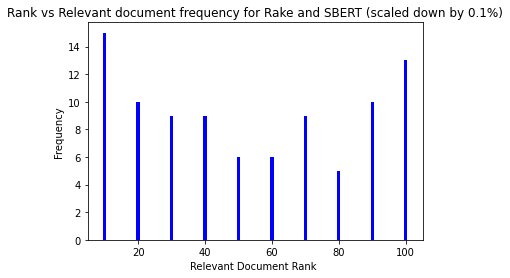

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

data = []
data.append(graphRanksCase)
# data.append(counter9)
# data.append(counter10)

X = np.arange(10,110,10)
plt.bar(X+0, data[0], color = 'b', width = 1)
# plt.bar(X+1.25, data[1], color = 'r', width = 1)
# plt.bar(X+2.50, data[2], color = 'g', width = 1)
plt.xlabel("Relevant Document Rank ")
plt.ylabel("Frequency")
plt.title("Rank vs Relevant document frequency for Rake and SBERT (scaled down by 0.1%)")
plt.show()

Graph for statutes

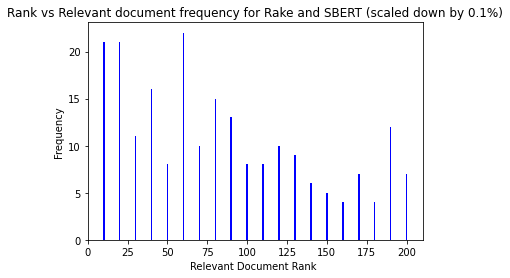

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

data = []
data.append(graphRanksStatutes)
# data.append(counter9)
# data.append(counter10)

X = np.arange(10,210,10)
plt.bar(X+0, data[0], color = 'b', width = 1)
# plt.bar(X+1.25, data[1], color = 'r', width = 1)
# plt.bar(X+2.50, data[2], color = 'g', width = 1)
plt.xlabel("Relevant Document Rank ")
plt.ylabel("Frequency")
plt.title("Rank vs Relevant document frequency for Rake and SBERT (scaled down by 0.1%)")
plt.show()